In [ ]:
!pip install datasets
!pip install transformers torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset
ds = load_dataset("LuminaAI/RCL-Breast-Cancer-Biopsy-7500")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.28k [00:00<?, ?B/s]

Breast_Cancer_Biopsy_7500.zip:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [ ]:
from transformers import pipeline
pipe = pipeline("image-classification", model="microsoft/resnet-50")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

In [ ]:
# prompt: Split the data in ds into a training and testing split of 85-15 randomly as train_ds and test_ds, showing the count of both

train_ds, test_ds = ds['train'].train_test_split(test_size=0.15, seed=42).values()
print(f"Training dataset size: {len(train_ds)}")
print(f"Testing dataset size: {len(test_ds)}")

Training dataset size: 6375
Testing dataset size: 1125


In [ ]:
# VERSION 1 - ACC 90%

# prompt: Fit the RESNET50 model on the training data and then test on testing data. Show the confusion matrix, ROC curve, learning curve and the other metrices. ALSO, give a seperate option to modify and play with at least 10 hyperparameters for customization

from transformers import pipeline
from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset
import torch
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Hyperparameters (with options for modification)
batch_size = 32 #@param {type:"integer"}
learning_rate = 0.005 #@param {type:"number"}
epochs = 3 #@param {type:"integer"}
weight_decay = 0.01 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
num_workers = 2 #@param {type:"integer"}
image_size = 224 #@param {type:"integer"}
optimizer_choice = "SGD" #@param ["AdamW", "SGD"]
scheduler_choice = "StepLR" #@param ["StepLR", "ReduceLROnPlateau"]
step_size = 3 #@param {type:"integer"}
gamma = 0.1 #@param {type:"number"}


# Data Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def transform_images(examples):
    examples['pixel_values'] = [transform(image.convert("RGB")) for image in examples['image']]
    del examples['image']
    return examples

train_ds = train_ds.with_transform(transform_images)
test_ds = test_ds.with_transform(transform_images)

# Create DataLoaders
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Optimizer and scheduler
if optimizer_choice == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_choice == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

if scheduler_choice == "StepLR":
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_choice == "ReduceLROnPlateau":
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_dataloader):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    if scheduler_choice == "StepLR":
      scheduler.step()


  0%|          | 0/30 [00:19<?, ?it/s]


KeyError: 'labels'

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 1/3


100%|██████████| 34/34 [04:21<00:00,  7.70s/it]


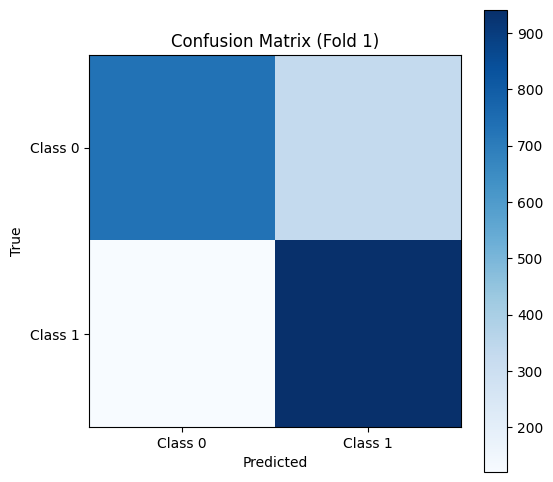

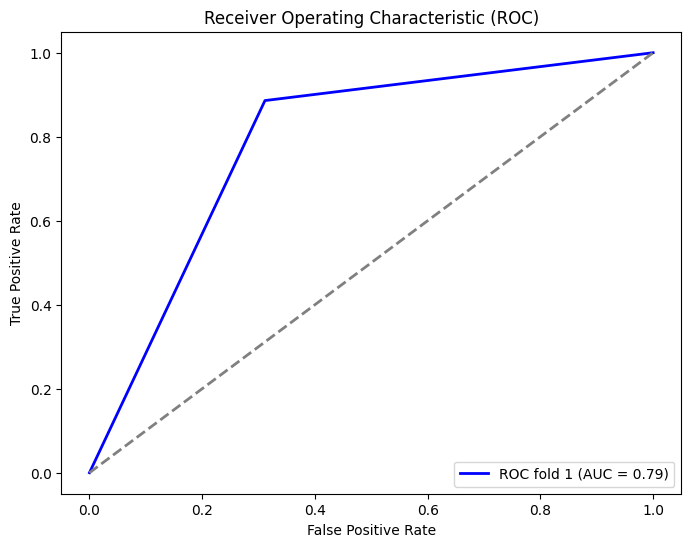

Training fold 2/3


100%|██████████| 34/34 [04:22<00:00,  7.73s/it]


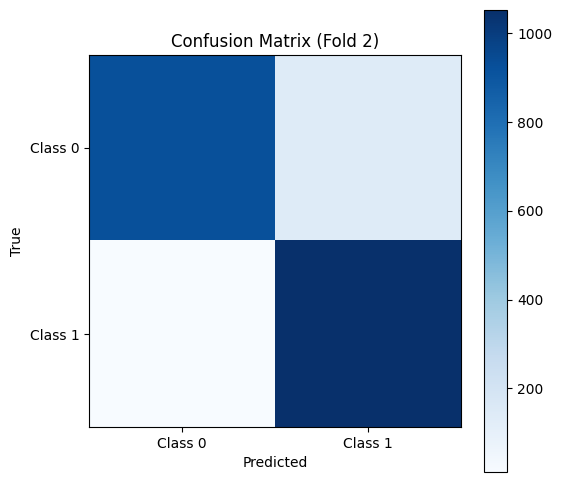

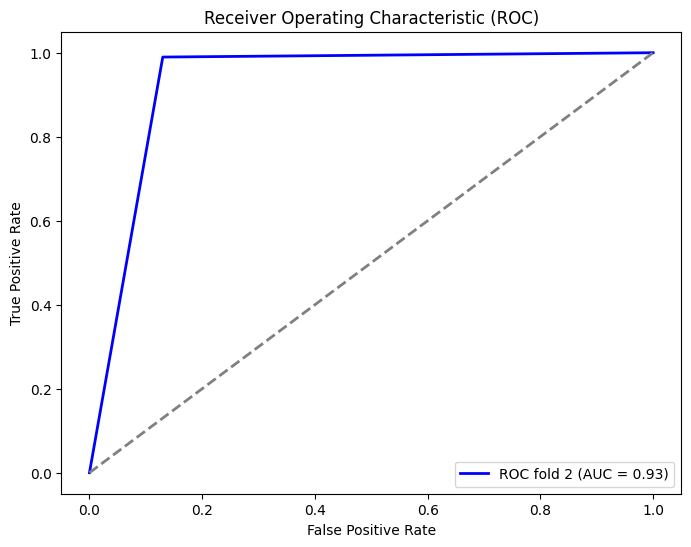

Training fold 3/3


100%|██████████| 34/34 [04:22<00:00,  7.71s/it]


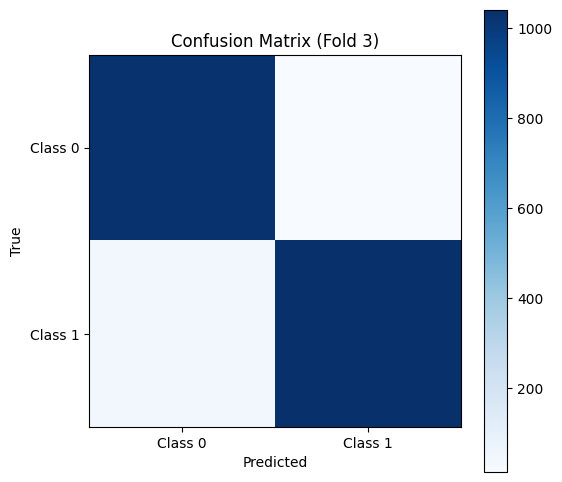

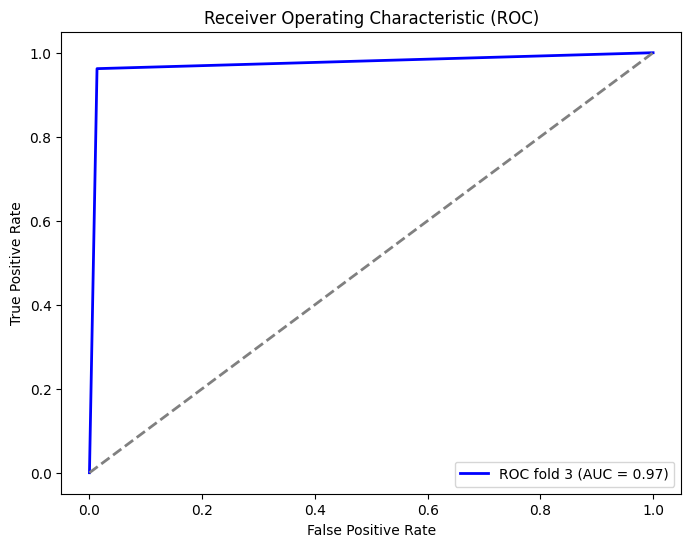


Average Classification Report across all folds:


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U53'), dtype('<U53')) -> None

In [ ]:
# VERSION 2

from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset
import torch
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torchvision.transforms as transforms

# Hyperparameters (with options for modification)
batch_size = 64 #@param {type:"integer"}
learning_rate = 0.01 #@param {type:"number"}
epochs = 3 #@param {type:"integer"}
weight_decay = 0.01 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
num_workers = 2 #@param {type:"integer"}
image_size = 224 #@param {type:"integer"}
optimizer_choice = "SGD" #@param ["AdamW", "SGD"]
scheduler_choice = "StepLR" #@param ["StepLR", "ReduceLROnPlateau"]
step_size = 3 #@param {type:"integer"}
gamma = 0.1 #@param {type:"number"}
k_folds = 3  # Number of folds for cross-validation

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def transform_images(examples):
    examples['pixel_values'] = [transform(image.convert("RGB")) for image in examples['image']]
    del examples['image']
    return examples

train_ds = train_ds.with_transform(transform_images)
test_ds = test_ds.with_transform(transform_images)

# KFold Cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to device BEFORE training loop
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2, # Specify the number of classes
    ignore_mismatched_sizes=True # Ignore size mismatches in loading the state dict
).to(device)

# Store metrics
confusion_matrices = []
roc_curves = []
class_reports = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_ds)):
    print(f"Training fold {fold+1}/{k_folds}")

    # Split the dataset into train and validation subsets for this fold
    train_subset = Subset(train_ds, train_idx)
    val_subset = Subset(train_ds, val_idx)

    # Create DataLoaders for this fold
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Optimizer and scheduler
    if optimizer_choice == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    if scheduler_choice == "StepLR":
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_choice == "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_dataloader):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        if scheduler_choice == "StepLR":
            scheduler.step()

    # Evaluate on validation data
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = model(pixel_values=pixel_values)
            _, preds = torch.max(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics for this fold
    cm = confusion_matrix(all_labels, all_preds)
    confusion_matrices.append(cm)

    # Classification Report
    report = classification_report(all_labels, all_preds)
    class_reports.append(report)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))

    # Plot metrics for this fold (confusion matrix, ROC curve)
    # Confusion Matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Fold {fold+1})')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
    plt.yticks(np.arange(2), ['Class 0', 'Class 1'])
    plt.show()

    # ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC fold {fold+1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Aggregate results from all folds
average_cm = np.mean(confusion_matrices, axis=0)
average_roc_auc = np.mean([roc_auc for _, _, roc_auc in roc_curves])

# Print average classification report
print("\nAverage Classification Report across all folds:")
print(np.mean([np.array(report.splitlines()) for report in class_reports], axis=0))

# Plot the average confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(average_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])
plt.show()

# Final ROC Curve
plt.figure(figsize=(8, 6))
for fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Average ROC Curve (AUC = {average_roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model_save_path = '/content/drive/MyDrive/STATS_507/breast_cancer_classifier_full_Kfolds.pth' # Change this to your desired path
torch.save(model, model_save_path)

print(f"Model saved to: {model_save_path}")


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 1/3


100%|██████████| 34/34 [04:23<00:00,  7.74s/it]


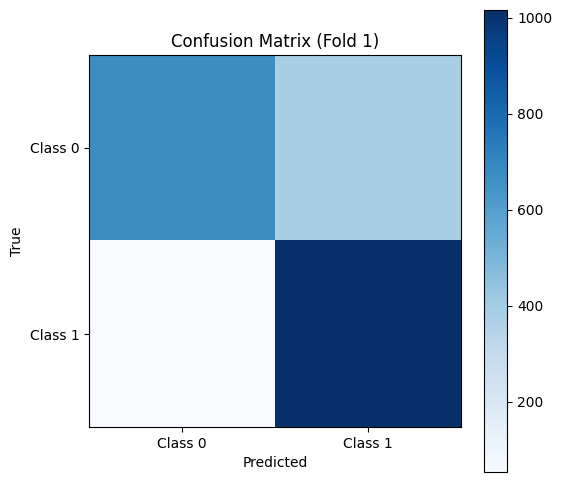

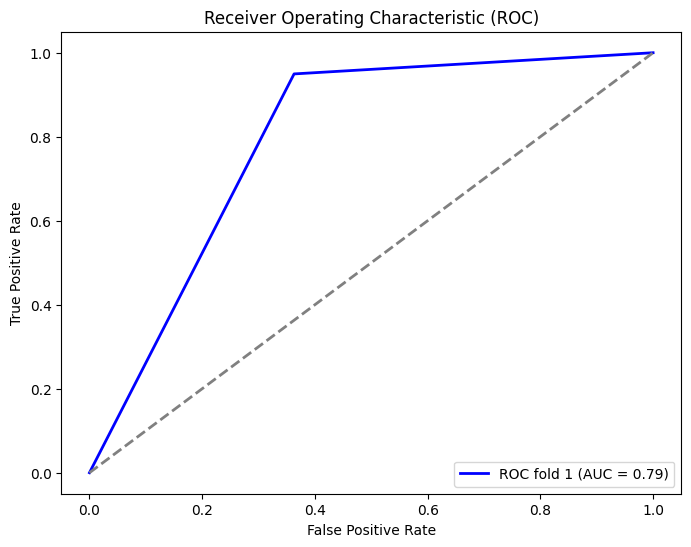

Training fold 2/3


100%|██████████| 34/34 [04:33<00:00,  8.04s/it]


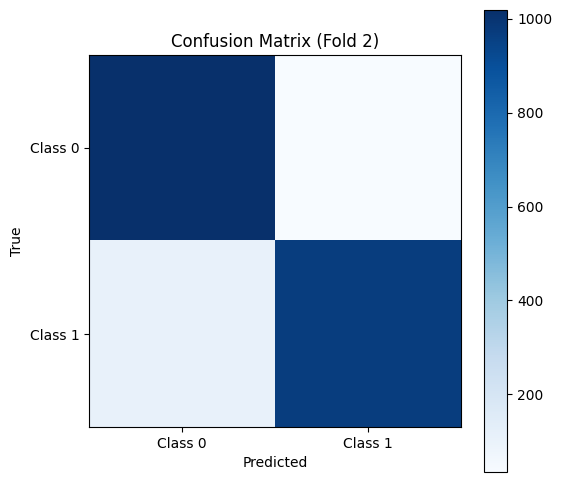

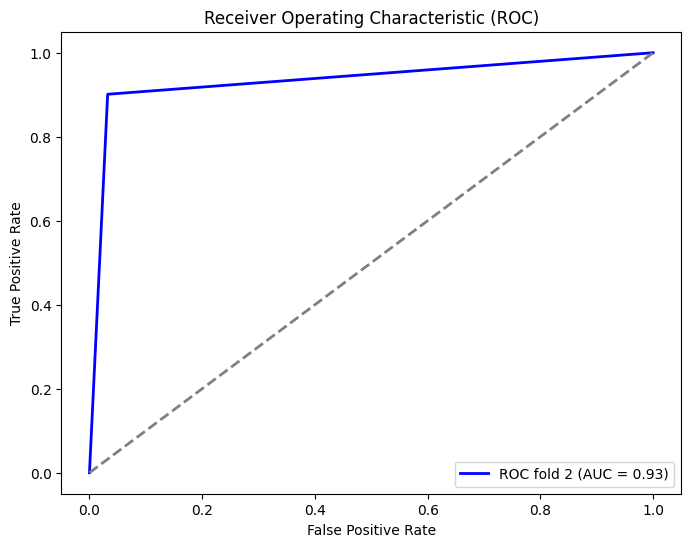

Training fold 3/3


100%|██████████| 34/34 [04:43<00:00,  8.34s/it]


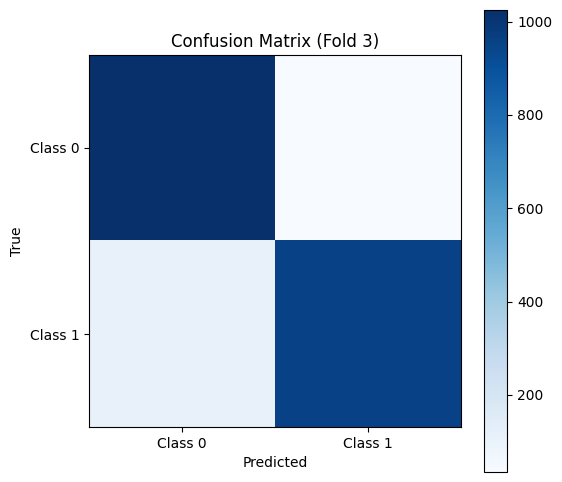

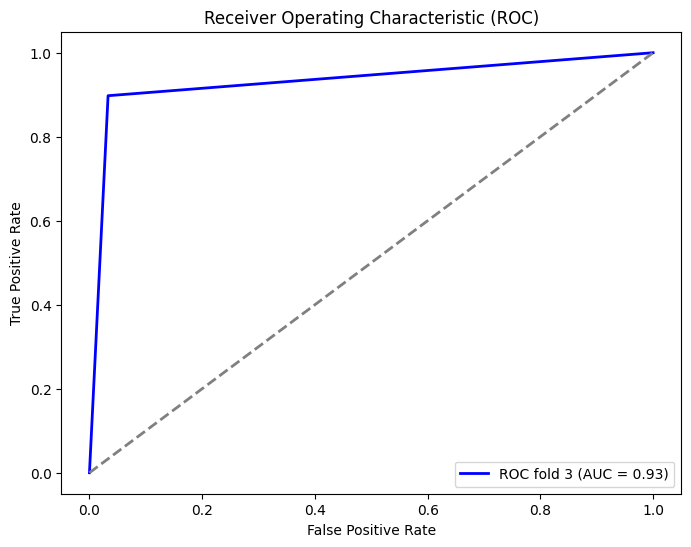

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/STATS_507/breast_cancer_classifier_full_Kfolds_v2.pth

Classification Reports for each fold:
Fold 1:
              precision    recall  f1-score   support

           0       0.93      0.64      0.75      1055
           1       0.73      0.95      0.82      1070

    accuracy                           0.79      2125
   macro avg       0.83      0.79      0.79      2125
weighted avg       0.83      0.79      0.79      2125

Fold 2:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1053
           1       0.97      0.90      0.93      1072

    accuracy                           0.93      2125
   macro avg       0.94      0.93      0.93      2125
weighted avg       0.94      0.93      0.93      2125

Fold 3:
              precision    recall  f1-score   support

      

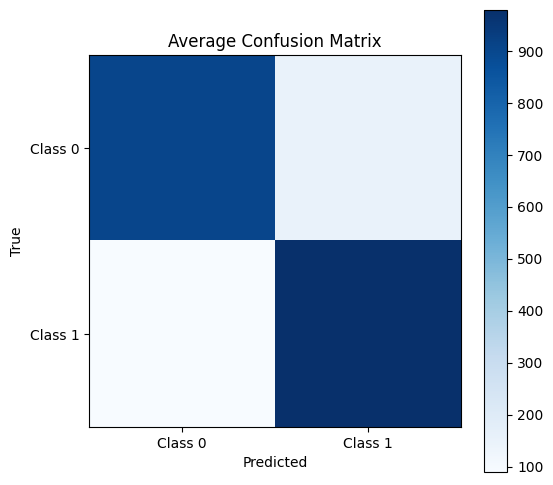

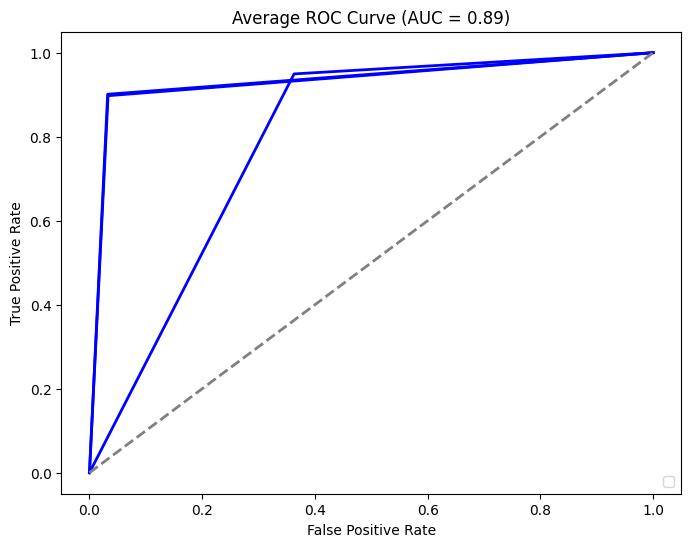

In [ ]:
# VERSION 3 (V2.KFolds)

# prompt: Write full code to train the model to generate better accuracy from the model for predictions

from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset
import torch
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torchvision.transforms as transforms

# Hyperparameters (with options for modification)
batch_size = 64 #@param {type:"integer"}
learning_rate = 0.0075 #@param {type:"number"}
epochs = 3 #@param {type:"integer"}
weight_decay = 0.01 #@param {type:"number"}
momentum = 0.92 #@param {type:"number"}
num_workers = 2 #@param {type:"integer"}
image_size = 224 #@param {type:"integer"}
optimizer_choice = "AdamW" #@param ["AdamW", "SGD"]
scheduler_choice = "ReduceLROnPlateau" #@param ["StepLR", "ReduceLROnPlateau"]
step_size = 3 #@param {type:"integer"}
gamma = 0.1 #@param {type:"number"}
k_folds = 3  # Number of folds for cross-validation

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def transform_images(examples):
    examples['pixel_values'] = [transform(image.convert("RGB")) for image in examples['image']]
    del examples['image']
    return examples

train_ds = train_ds.with_transform(transform_images)
test_ds = test_ds.with_transform(transform_images)

# KFold Cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to device BEFORE training loop
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2, # Specify the number of classes
    ignore_mismatched_sizes=True # Ignore size mismatches in loading the state dict
).to(device)

# Store metrics
confusion_matrices = []
roc_curves = []
class_reports = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_ds)):
    print(f"Training fold {fold+1}/{k_folds}")

    # Split the dataset into train and validation subsets for this fold
    train_subset = Subset(train_ds, train_idx)
    val_subset = Subset(train_ds, val_idx)

    # Create DataLoaders for this fold
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Optimizer and scheduler
    if optimizer_choice == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    if scheduler_choice == "StepLR":
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_choice == "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_dataloader):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        if scheduler_choice == "StepLR":
            scheduler.step()

    # Evaluate on validation data
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = model(pixel_values=pixel_values)
            _, preds = torch.max(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics for this fold
    cm = confusion_matrix(all_labels, all_preds)
    confusion_matrices.append(cm)

    # Classification Report
    report = classification_report(all_labels, all_preds)
    class_reports.append(report)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))

    # Plot metrics for this fold (confusion matrix, ROC curve)
    # Confusion Matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Fold {fold+1})')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
    plt.yticks(np.arange(2), ['Class 0', 'Class 1'])
    plt.show()

    # ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC fold {fold+1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model_save_path = '/content/drive/MyDrive/STATS_507/breast_cancer_classifier_full_Kfolds_v2.pth' # Change this to your desired path
torch.save(model, model_save_path)

print(f"Model saved to: {model_save_path}")


# Aggregate results from all folds
average_cm = np.mean(confusion_matrices, axis=0)
average_roc_auc = np.mean([roc_auc for _, _, roc_auc in roc_curves])

# Print individual classification reports instead of averaging strings
print("\nClassification Reports for each fold:")
for fold, report in enumerate(class_reports):
    print(f"Fold {fold+1}:")
    print(report)


# Print the average confusion matrix with exact values
print("\nAverage Confusion Matrix (with exact values):")
print(average_cm)

# Extract and print precision, recall, F1-score from the classification reports
precisions = []
recalls = []
f1_scores = []
for report in class_reports:
    lines = report.splitlines()
    for line in lines[2:-3]:  # Extract the relevant lines
        parts = line.split()
        if len(parts) >= 5 and parts[0].isdigit():  # Check if the line has enough elements and the first element is a digit for class label
            precisions.append(float(parts[1]))
            recalls.append(float(parts[2]))
            f1_scores.append(float(parts[3]))
print("\nAverage Precision:", np.mean(precisions))
print("Average Recall:", np.mean(recalls))
print("Average F1-score:", np.mean(f1_scores))

# Calculate and print the average accuracy
accuracies = [np.trace(cm) / np.sum(cm) for cm in confusion_matrices]
average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)


# Plot the average confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(average_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])
plt.show()

# Final ROC Curve
plt.figure(figsize=(8, 6))
for fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Average ROC Curve (AUC = {average_roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()



In [ ]:
# VERSION 2

from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model_save_path = '/content/drive/MyDrive/STATS_507/breast_cancer_classifier_full_Kfolds.pth' # Change this to your desired path
torch.save(model, model_save_path)

print(f"Model saved to: {model_save_path}")

Mounted at /content/drive
Model saved to: /content/drive/MyDrive/STATS_507/breast_cancer_classifier_full_Kfolds.pth


In [ ]:
# VERSION 2

# Aggregate results from all folds
average_cm = np.mean(confusion_matrices, axis=0)
average_roc_auc = np.mean([roc_auc for _, _, roc_auc in roc_curves])

# Print individual classification reports instead of averaging strings
print("\nClassification Reports for each fold:")
for fold, report in enumerate(class_reports):
    print(f"Fold {fold+1}:")
    print(report)


Classification Reports for each fold:
Fold 1:
              precision    recall  f1-score   support

           0       0.86      0.69      0.76      1063
           1       0.74      0.89      0.81      1062

    accuracy                           0.79      2125
   macro avg       0.80      0.79      0.79      2125
weighted avg       0.80      0.79      0.79      2125

Fold 2:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1061
           1       0.88      0.99      0.93      1064

    accuracy                           0.93      2125
   macro avg       0.94      0.93      0.93      2125
weighted avg       0.94      0.93      0.93      2125

Fold 3:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1044
           1       0.99      0.96      0.97      1081

    accuracy                           0.97      2125
   macro avg       0.97      0.97      0.97      2125
weighted av

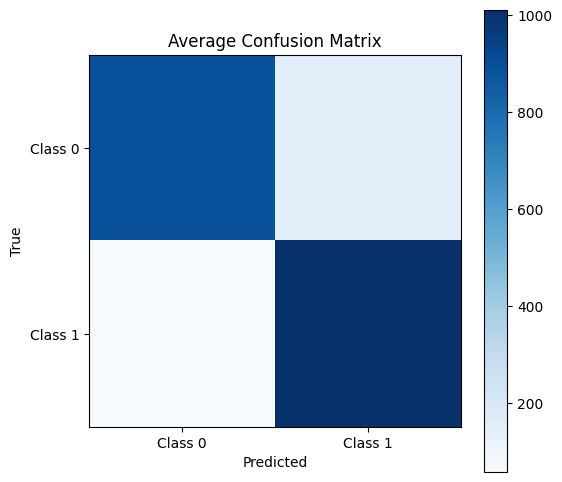

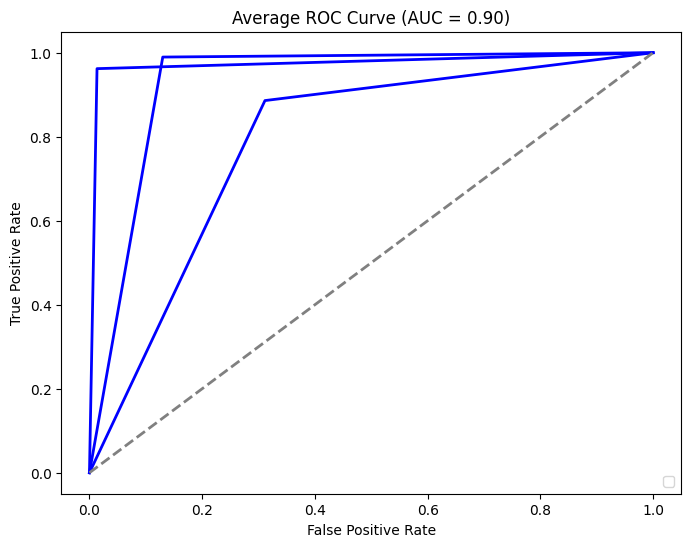

In [ ]:
# VERSION 2

plt.figure(figsize=(6, 6))
plt.imshow(average_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])
plt.show()

# Final ROC Curve
plt.figure(figsize=(8, 6))
for fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Average ROC Curve (AUC = {average_roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# VERSION 2

# Print the average confusion matrix with exact values
print("\nAverage Confusion Matrix (with exact values):")
print(average_cm)

# Extract and print precision, recall, F1-score from the classification reports
precisions = []
recalls = []
f1_scores = []
for report in class_reports:
    lines = report.splitlines()
    for line in lines[2:-3]:  # Extract the relevant lines
        parts = line.split()
        if len(parts) >= 5 and parts[0].isdigit():  # Check if the line has enough elements and the first element is a digit for class label
            precisions.append(float(parts[1]))
            recalls.append(float(parts[2]))
            f1_scores.append(float(parts[3]))
print("\nAverage Precision:", np.mean(precisions))
print("Average Recall:", np.mean(recalls))
print("Average F1-score:", np.mean(f1_scores))

# Calculate and print the average accuracy
accuracies = [np.trace(cm) / np.sum(cm) for cm in confusion_matrices]
average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)


Average Confusion Matrix (with exact values):
[[ 895.          161.        ]
 [  57.66666667 1011.33333333]]

Average Precision: 0.9033333333333333
Average Recall: 0.8983333333333334
Average F1-score: 0.895
Average Accuracy: 0.8970980392156863


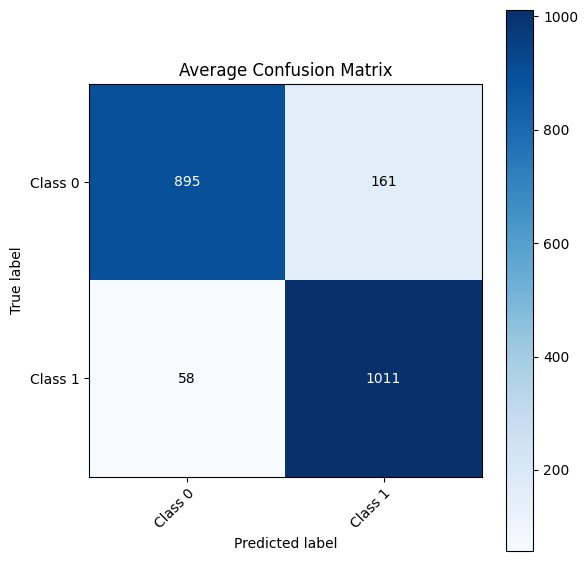

In [ ]:
# VERSION 2

# prompt: Write code to get figure for cm

import matplotlib.pyplot as plt

# Assuming 'average_cm' is your confusion matrix (calculated in the previous code)
# Example:
# average_cm = np.array([[90, 10], [5, 95]])

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# Display the confusion matrix as an image
im = ax.imshow(average_cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the title and axis labels
ax.set(xticks=np.arange(average_cm.shape[1]),
       yticks=np.arange(average_cm.shape[0]),
       xticklabels=['Class 0', 'Class 1'],  # Assuming you have two classes
       yticklabels=['Class 0', 'Class 1'],
       title='Average Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = average_cm.max() / 2.
for i in range(average_cm.shape[0]):
    for j in range(average_cm.shape[1]):
        ax.text(j, i, format(average_cm[i, j], '.0f'),  # changed 'd' to '.0f'
                ha="center", va="center",
                color="white" if average_cm[i, j] > thresh else "black")

# Adjust layout for better spacing
fig.tight_layout()

# Display the plot
plt.show()

In [ ]:
# VERSION 1 - TRAINING

# Load the entire model
model = torch.load('breast_cancer_classifier_full.pth')
# model.eval()

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
print(classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{cm}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# VERSION 1 - SAVE MODEL

# prompt: Write code to save this model on google drive

from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model_save_path = '/content/drive/MyDrive/STATS_507/breast_cancer_classifier_full.pth' # Change this to your desired path
torch.save(model, model_save_path)

print(f"Model saved to: {model_save_path}")

Mounted at /content/drive
Model saved to: /content/drive/MyDrive/STATS_507/breast_cancer_classifier_full.pth
